In [1]:
%matplotlib inline 

In [2]:
image_path = '/home/morten/Git_and_dropbox_not_friends/Retina/Pems/35058_left.png'
# image_save_path = ('/home/morten/Git_and_dropbox_not_friends/Retina/'
# 'testing_images_notebook')

In [3]:
from scipy import ndimage
import skimage.feature
import os 
import skimage.io
import skimage.color
import numpy as np
import matplotlib.pyplot as plt
import sys
import PIL.Image

# Functions


In [4]:
def do_nothing_fun(input):
    return input


def image_load(path):
    image = skimage.io.imread(path)   
    return path, image


def image_save((image,name,path)):
    save_as = os.path.join(path,name)
    save_as = os.path.relpath(save_as)
    skimage.io.imsave(save_as, image)
    return 0


def get_name_image(image_path):
    name = image_path.split('/')[-1]
    return name


def name_to_name_and_path(list):
    """list should be a list of pathnames to the images"""
    paths = np.asarray(list).copy().reshape(len(list),1).shape
    names = np.vectorize(get_name_image)
    return np.concatenate((name,paths),axis=1)


def transform_pipeline(*functions):
    """Functional programming ;)"""
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions)


def main():
    global development
    development = True
    image_out_id = "512_with_special_sauce"
    directory = '/home/morten/Git_and_dropbox_not_friends/Retina/sample'
    save_out = os.path.join(directory, image_out_id)
    if not os.path.exists(save_out):
        os.makedirs(save_out, mode=0755)
    image_names = glob.glob(os.path.join(directory,"*.jpeg"))
    image_names.sort
    for i in image_names:
        print "globbed %s" % i

    # Doing it in parallel
    # Note that the input/outputs need to match 
    num_cores = multiprocessing.cpu_count()
    transform_image = transform_pipeline(image_load, image_save)
    results = Parallel(n_jobs=num_cores)(delayed(transform_image)(i) for i in images_names) 
    return 0 


def return_zero(input):
    print "length of inputs are %d" % len(input)
    print "and path is %s" % input[0]
    return input[-1]

def flatten_hist(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255.0/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    img = cdf[img]
    return img


In [5]:
def remove_background_noise(image):
    """Watch out, this function transforms inplace"""
    h, w = image.shape[:2]
    ma = np.mean(image,axis=2)
    v = ma[np.rint(h/4):np.rint(3*h/4),np.rint(w/4):np.rint(3*w/4)]
    threshold = max(np.max(0.3*np.median(v)), 0.75*np.min(v))
    mask = (ma < threshold) 
    image[mask]= 0
    return image

def convert_to_uin8(image):
    return image.astype(uint8)


def rotate_90_degrees(image,direction='clockwise'):
    try:
        assert(direction=='clockwise' or direction=='counterclockwise')
    except AssertionError:
        print 'direction argument to "roate_90_degrees" must be "clockwise" or "counterclockwise"'  
        sys.exit()
    # test if greyscale
    if len(image.shape)<3:
        image = image.T
    else:
        image = np.transpose(image, (1, 0, 2))
        
    if direction == 'counterclockwise':
        image = np.flipud(image)
    
    return image

In [6]:
def normalize(img):
    """Not quite normalizing but rather making sure numbers are in teh interval 0-255"""
    """also sets to uint8"""
    min = np.amin(img)
    img = img-min
    max = np.amax(img)
    img = img/255.0
    img = img*255
    img = img.astype(np.uint8)
    return img

def rgb_to_yiq(img):
    img = normalize(img)
    img[:,:,0]=img[:,:,0]/255.0
    img[:,:,1]=(img[:,:,1]-255/2.0)*0.5957
    img[:,:,2]=(img[:,:,2]-255/2.0)*0.5229
    A = np.array([[0.299, 0.587, 0.114],[0.596,-0.275,-0.321],[0.212,-0.528,0.311]])
    A_test = np.array([[1, 0.956, 0.621],[1, -0.272, -0.321],[1, -1.108, 1.705]])
    
    h,w = img.shape[:2]
    for i in xrange(h):
        for j in xrange(w):   
            img[i,j,:] = np.dot(img[i,j,:],A)
            #img_test = np.dot(img,A_test)
    img = img.astype(np.uint8)
    #img_test = img_test.astype(np.uint8)
    return img #, img_test

# This should work though, and I think yiq and hsv are similar
def from_rgb_to_hsv(im):
    return skimage.color.convert_colorspace(im,'RGB','HSV')

In [11]:
def pil_resize(image_path,image_save_path,size):
    name = get_name_image(image_path)
    im = PIL.Image.open(image_path)
    im.thumbnail((size, size), PIL.Image.LANCZOS)
    d = {key: value for (key, value) in zip(['w','h'],im.size)}
    dim_max = max(d,key=d.get)
    dim_min = min(d,key=d.get)
    dif = size - d[dim_min]
    c = dif//2
    d[dim_min]=d[dim_min]+dif%2
    d[dim_max] = [0+c,d[dim_max]-c]
    d[dim_min] = [0,d[dim_min]]
    lower, upper, left, right = [element for tpl in d.values() for element in tpl]
    box = (left, lower, right, upper)
    im=im.crop(box)
    name = name.replace("jpeg","png")
    outfile = os.path.join(image_save_path,name)
    im.save(outfile)

Tested functions

- [x]  do_nothing_fun
- [x]  image_load
- [x]  get_name_image
- [x]  image_save
- [ ]  name_to_name_and_path # Can't very well test that here.
- [ ]  transform_pipeline # not tested here, but tested elsewhere
- [ ]  return_zero  # tested elsewhere, but also trivial
- [x]  remove_back_ground_noise
- [ ]  rgb_to_yiq  # Seriously I can't get this to work.  There's also the converter for 3 at the bottom using colorsys.  I think my solution might be with opencv 
- [x]  normalize...seems to be working
- [x]  flatten_hist 

In [8]:
image = image_load(image_path)[1]
image_name = get_name_image(image_path)
# image_save((image,image_name,image_save_path))

In [9]:
image_path

'/home/morten/Git_and_dropbox_not_friends/Retina/Pems/35058_left.png'

In [10]:
b = image.copy()

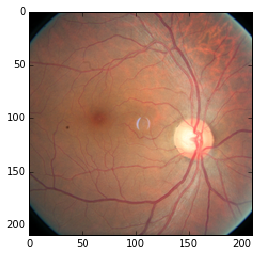

In [11]:
skimage.io.imshow(b)

61.25


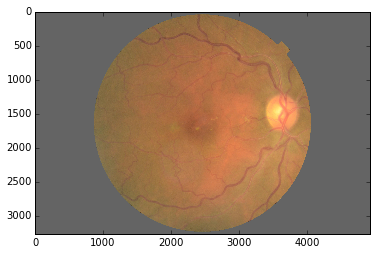

In [18]:
b = remove_background_noise(b)
plt.figure()
skimage.io.imshow(b)

# Turning 90 degrees
But what way to turn depends on the mistake...I could write some code that looks at where the blindspot is, combine with the name left right, and flip accordingly, but would be too much work. Just put a note into a shared file with potential errors.  It seems there's a little notch in the picture, that's always on the right side

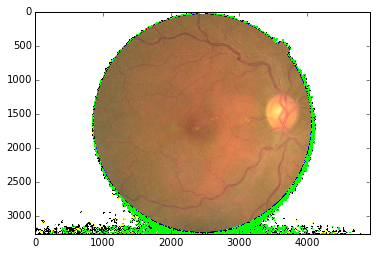

In [71]:
skimage.io.imshow(image)

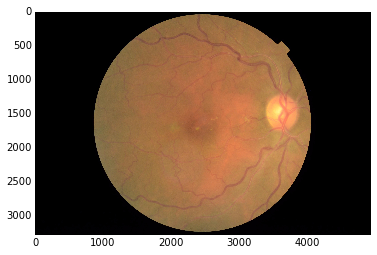

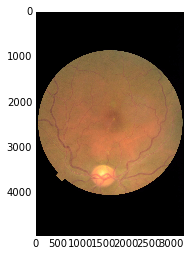

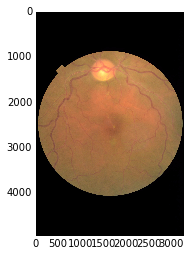

In [67]:
image = skimage.io.imread(image_path)
h,w,_= image.shape
plt.figure()
skimage.io.imshow(image)
rotated_image = np.transpose(image, (1, 0, 2))
plt.figure()
skimage.io.imshow(rotated_image)
plt.figure()
skimage.io.imshow(np.flipud(rotated_image))

# Remove noise fromt he black background

R G B (Red, Green ,Blue) is of 8-bit each. Thus maximum possible range by individual is 0-255 (as 2^8 = 256). 

/home/morten/.virtualenvs/Ez2Ec2/local/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warnings.warn("Float image out of standard range; displaying "


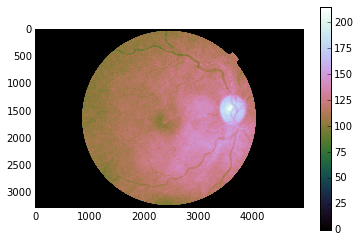

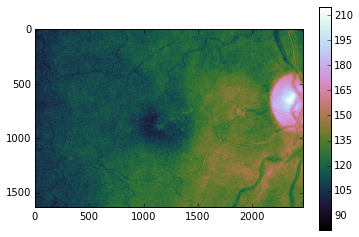

In [6]:
ma = np.mean(image,axis=2)


# Isn't there a smoother way to do this, like in matlab with using end, like end/4:3*end/4
v = ma[np.rint(h/4):np.rint(3*h/4),np.rint(w/4):np.rint(3*w/4)]

plt.figure()
skimage.io.imshow(ma)

plt.figure()
skimage.io.imshow(v)

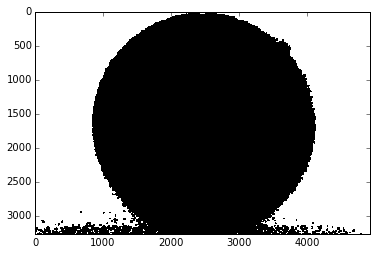

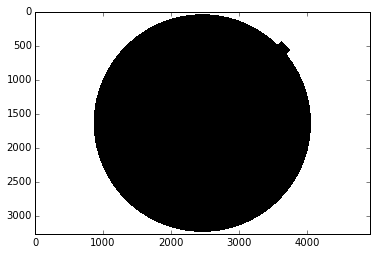

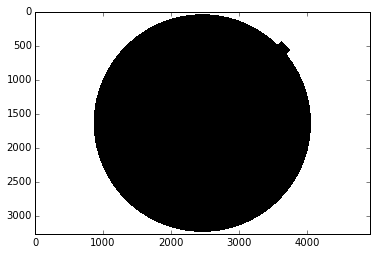

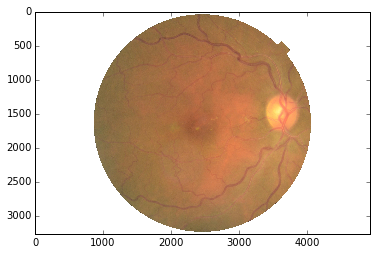

In [49]:
# As we can see there's some noise along the background
plt.figure()
skimage.io.imshow(ma==0)


# In this image it seems we can safely remove intensities less than 50% of the median of the center, but to be sure
# I'll use 30% like marco 
plt.figure()
skimage.io.imshow(ma/np.median(v)<0.50)

# Or I could just use every pixel intensity less than the minimum of the center(v) or 30% of median if I somehow get a very dark pixel
# So np.max(np.min(v), np.median(v)<30)
plt.figure()
threshold = max(np.max(0.3*ma/np.median(v)), 0.75*np.min(v))
skimage.io.imshow(ma<threshold)

#filter
image_no_back_ground_noise_filter = (ma < threshold) 

image_background_noise_removed = image.copy()
image_background_noise_removed[image_no_back_ground_noise_filter] = 255

plt.figure()
skimage.io.imshow(image2)



# Edge detection
Python: cv2.Canny(image, threshold1, threshold2[, edges[, apertureSize[, L2gradient]]]) → edges

I can't get cv2 to work :(

# Convert to gray

In [12]:
def rgb2gray(rgb):
    grey = skimage.color.rgb2gray(rgb)
    return grey

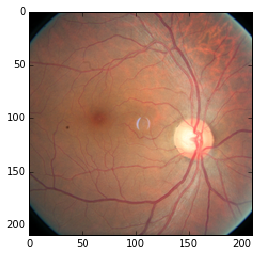

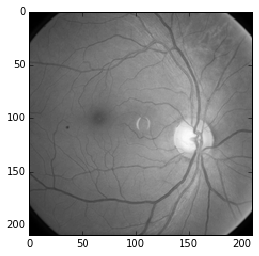

In [13]:
plt.figure()
skimage.io.imshow(image)
im_gray = rgb2gray(image)
plt.figure()
skimage.io.imshow(im_gray)

In [14]:
h, w = image.shape[:2]
ma = np.mean(image,axis=2)
v = ma[np.rint(h/4):np.rint(3*h/4),np.rint(w/4):np.rint(3*w/4)]
med = np.median(v)
ma = ma/float(med)

255
0


/home/morten/.virtualenvs/Ez2Ec2/local/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warnings.warn("Float image out of standard range; displaying "


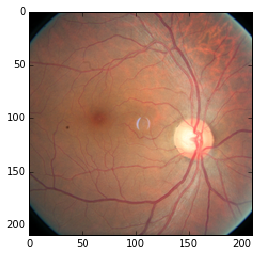

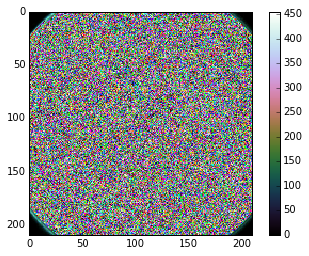

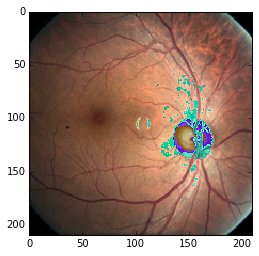

In [15]:
plt.figure()
skimage.io.imshow(image)
extr = (ma[:,:,np.newaxis]*image)
plt.figure()
skimage.io.imshow(extr)
extr2 = normalize(extr)
plt.figure()
skimage.io.imshow(extr2)
print extr2.max()
print extr2.min()

In [16]:
edges = np.mean((ma[:,:,np.newaxis]*image),axis=2)
print edges.max()
print edges.min()
edges2 = edges.copy()
edges2 = normalize(edges2)/255.0
print edges2.max()
print edges2.min()

# edges = skimage.feature.canny(edges,sigma=1.0,low_threshold=0, high_threshold=255)

443.16464891
0.0
1.0
0.0


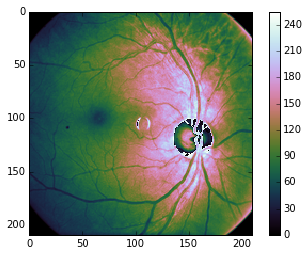

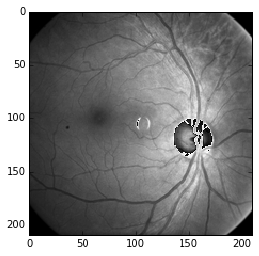

In [17]:
plt.figure()
skimage.io.imshow(edges2*255)
plt.figure()
skimage.io.imshow(edges2)

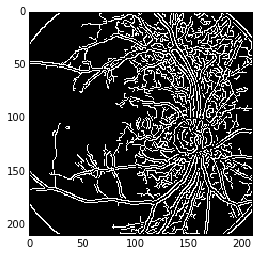

In [18]:
plt.figure()
ed = skimage.feature.canny(edges2,sigma=0.5)
skimage.io.imshow(ed)

In [152]:
im_gray.min()

0.0

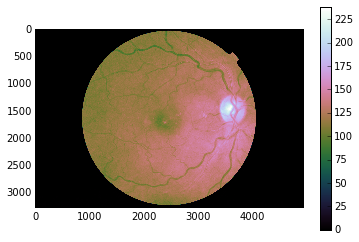

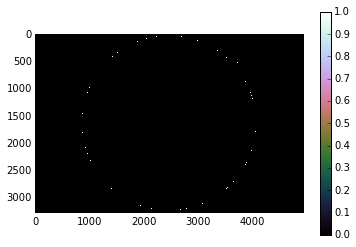

In [157]:
plt.figure()
skimage.io.imshow(im_gray)

plt.figure()
edges = skimage.feature.canny(im_gray*255,sigma=1.0,low_threshold=0, high_threshold=255)
skimage.io.imshow(edges)

# Scraps I didn't want to delete

In [74]:
def from_rgb_to_hsv(im):
    return skimage.color.convert_colorspace(im,'RGB','HSV')

In [75]:
img = image.copy()
h = from_rgb_to_hsv(img)

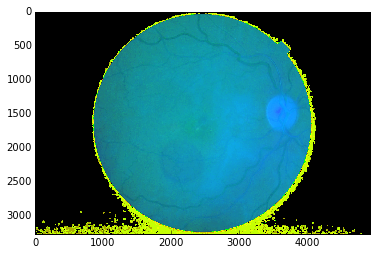

In [76]:
skimage.io.imshow(h)

In [71]:
np.amax(img)

255

In [78]:
type(cdf)

numpy.ndarray

In [87]:
cdf_normalized.shape

(256,)

In [91]:
hist.min()

3.1891137769938493e-05

In [92]:
hist.shape

(256,)

In [ ]:
plt.figure()
plt.hist(img.flatten(),256,[0,254])

In [95]:
hist.max()

22388665

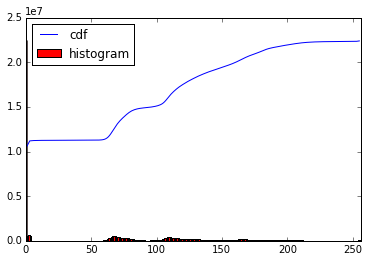

even though max is 255 almost all pixel values are around 0


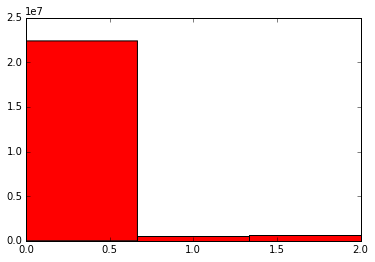

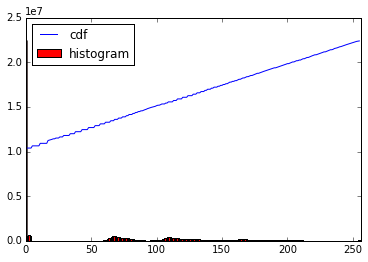

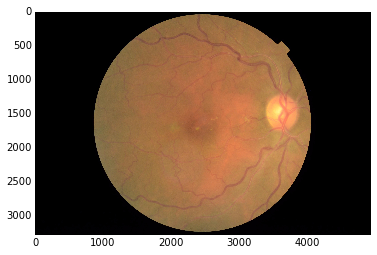

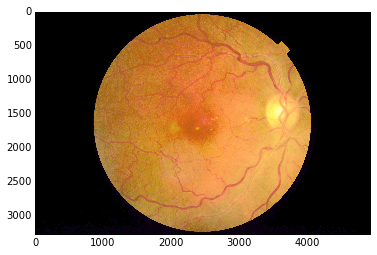

In [126]:
# this could be improved with cv2

img = image.copy()

hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.figure()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()
plt.figure()
plt.hist(img.flatten(),3,[0,2], color = 'r')
print "even though max is %d almost all pixel values are around 0" % img.max()


cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255.0/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = img.copy()
img2 = cdf[img2]

hist,bins = np.histogram(img2.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ float(cdf.max())

plt.figure()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()
plt.figure()
skimage.io.imshow(img)
plt.figure()
skimage.io.imshow(img2)


In [132]:
def flatten_hist(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255.0/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    img = cdf[img]
    return img

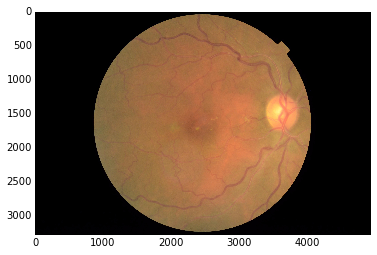

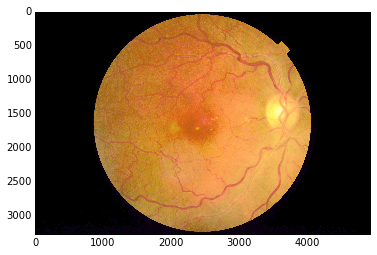

In [133]:
plt.figure()
skimage.io.imshow(image)

plt.figure()
img2 = image.copy()
img2 = flatten_hist(img2)
skimage.io.imshow(img2)

In [51]:
import skimage.feature
import os
import skimage.io
import skimage.color
import numpy as np
# import matplotlib.pyplot as plt
import sys
# from clint.textui import progress
import glob
# import time
# from memory_profiler import profile as memory_profiling
import multiprocessing
import functools
import pathos.multiprocessing as mp
import PIL.Image
import getopt

In [63]:
image_path = '/home/morten/Git_and_dropbox_not_friends/Retina/sample/'
image_save_path = ('/home/morten/Git_and_dropbox_not_friends/Retina/'
'testing_images_notebook')
directory = image_path
size = 1024

In [57]:
image_names = glob.glob(os.path.join(directory, "*.jpeg"))

In [58]:
image_names

['/home/morten/Git_and_dropbox_not_friends/Retina/sample/10_left.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/sample/15_left.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/sample/15_right.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/sample/17_right.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/sample/17_left.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/sample/16_right.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/sample/13_right.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/sample/test.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/sample/13_left.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/sample/16_left.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/sample/10_right.jpeg']

In [62]:
element2 = len(image_names)*[image_save_path]
element2

['/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook']

In [65]:
element3 = len(image_names)*[size]
element3

[1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]

In [68]:
out = zip(image_names,element2, element3)

In [71]:
type(out)

list

In [76]:
(out[1])

('/home/morten/Git_and_dropbox_not_friends/Retina/sample/15_left.jpeg',
 '/home/morten/Git_and_dropbox_not_friends/Retina/testing_images_notebook',
 1024)